# Reviewer 1 Response: Camphor Dataset

## Defining Paths

In [1]:
from pathlib import Path
import nmrespy as ne

root = Path("../..")
molecule = "camphor"
data_path = root / "data" / "camphor" / "1"
output_dir = root / "code" / "reviewer-1" / "output"
            
output_dir.mkdir(exist_ok=True, parents=True)

In [2]:
def get_estimator(save_path):
    if save_path.is_file():
        estimator = ne.Estimator2DJ.from_pickle(save_path)
    else:
        estimator = ne.Estimator2DJ.new_bruker(data_path)
        estimator.phase_data(p0=5.238, p1=-6.262)
        estimator.baseline_correction()
        estimator.to_pickle(save_path)
    return estimator

estimator_path = output_dir / "estimator_camphor.pkl"
estimator = get_estimator(estimator_path)

## View the 1D spectrum

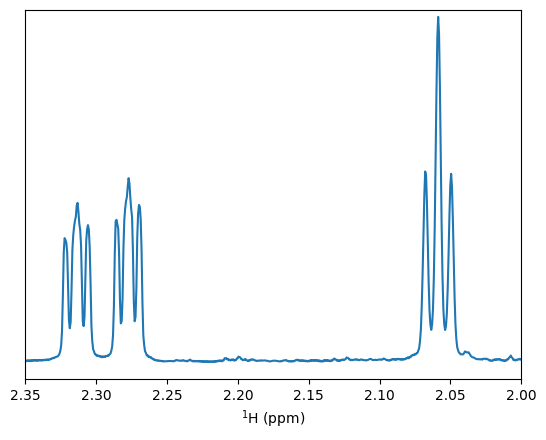

In [3]:
import copy
import matplotlib.pyplot as plt

region = (2.35, 2.0)

spectrum = copy.deepcopy(estimator._data[0])
spectrum = ne.sig.zf(spectrum)
spectrum[0] *= 0.5
spectrum = ne.sig.ft(spectrum).real
_, shifts = estimator.get_shifts(unit="ppm", pts=(1, spectrum.size), meshgrid=False)

fig, ax = plt.subplots()
ax.plot(shifts, spectrum)
ax.set_xlim(region[0], region[1]);
ax.set_ylim(-1.0e4, 2.0e5);
ax.set_yticks([])
ax.set_xlabel("$^{1}$H (ppm)");

## Running the Estimation

In [4]:
def run_estimation(
    estimator: ne.Estimator2DJ,
    regions: list[tuple[float, float]],
    rerun: bool,
    save_path: Path,
    **kwargs
) -> None:
    try:
        if rerun:
            estimator._results = []
        estimator.get_results()
    except ValueError:
        for region in regions: 
            estimator.estimate(region=region, **estimation_kwargs)
            estimator.to_pickle(save_path, force_overwrite=True)

The default convergence threshold for the optimisation routine is $10^{-8}$.
The optimiser is deemed to have converged once the norm of the gradient vector of the cost function is smaller than this threshold.

If the default threshold is used in the cell below, a very similar result is obtained, but the optimiser does not officially converge. Instead, at the 78th iteration, it is determined that the proposed parameter update does not lead to an improvement in the cost function, and so the routine is terminated. From approximately the 30th iterate onwards, the cost function remains effectively the same. Setting the convergence threshold to a larger value ($10^{-6}$ is used below) leads to successful convergence.

To see the impact of using the default threshold, remove the following line from the cell below:

    epsilon=1.0e-6,

and ensure that `rerun` is set to `True`.

In [5]:
# Set random seed for reproducibility
import numpy as np
np.random.seed(0)

rerun = True 
estimation_kwargs = dict(
    noise_region=(6.0, 5.0),
    region_unit="ppm",
    epsilon=1.0e-6,
)

In [6]:
%%time
run_estimation(
    estimator,
    [(2.35, 2.0)],
    rerun,
    estimator_path,
    **estimation_kwargs,
)

┌──────────────────────────────────────┐
│ESTIMATING REGION: 2.35 - 2.0 ppm (F2)│
└──────────────────────────────────────┘
┌─────────────┐
│MMEMP STARTED│
└─────────────┘
--> Computing number of oscillators...
	Number of oscillators will be estimated using MDL on first t1 increment.
	Number of oscillators: 25
--> Pencil parameters: 64, 128
--> Enhanced Block Hankel matrix constructed:
	Size: 8192 x 8385
	Memory: 1.0236GiB
--> Performing Singular Value Decomposition...
--> Checking for oscillators with negative damping...
	factors detected. These have been deleted.
	Corrected number of oscillations: 23
┌──────────────┐
│MMEMP COMPLETE│
└──────────────┘
Time elapsed: 0 mins, 10 secs, 500 msecs
┌────────────────────┐
│OPTIMISATION STARTED│
└────────────────────┘
┌───────────────────────────┐
│TRUST NCG ALGORITHM STARTED│
└───────────────────────────┘
┌───────┬──────────────┬──────────────┬──────────────┐
│ Iter. │  Objective   │  Grad. Norm  │ Trust Radius │
├───────┼──────────────┼──────

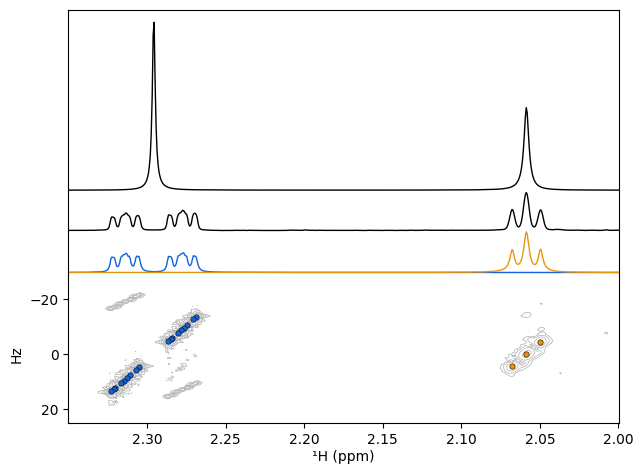

In [7]:
plot_kwargs = dict(
    axes_bottom=0.1,
    axes_left=0.1,
    region_unit="ppm",
    contour_base=4.0e3,
    contour_factor=2.0,
    contour_nlevels=10,
    contour_color="#b0b0b0",
    marker_size=15.0,
    multiplet_show_45=False,
    multiplet_show_center_freq=False,
)
fig, _ = estimator.plot_result(**plot_kwargs)
fig.savefig(output_dir / "camphor_result_full.png")

N.B. the routine runs more quickly if 2 separate regions are considered. In the cells below, a duplicate estimator object is created, and two smaller sub-FIDs are produced, which yields the same result as above in just over half the time (~24s vs ~14s on my computer).

In [8]:
split_estimator_path = estimator_path.with_name("estimator_camphor_split.pkl")
estimator_split = get_estimator(split_estimator_path)

In [9]:
%%time

run_estimation(
    estimator_split,
    [(2.35, 2.23), (2.1, 2.0)],
    rerun,
    split_estimator_path,
    **estimation_kwargs,
)

┌───────────────────────────────────────┐
│ESTIMATING REGION: 2.35 - 2.23 ppm (F2)│
└───────────────────────────────────────┘
┌─────────────┐
│MMEMP STARTED│
└─────────────┘
--> Computing number of oscillators...
	Number of oscillators will be estimated using MDL on first t1 increment.
	Number of oscillators: 17
--> Pencil parameters: 64, 54
--> Enhanced Block Hankel matrix constructed:
	Size: 3456 x 3575
	Memory: 0.1841GiB
--> Performing Singular Value Decomposition...
--> Checking for oscillators with negative damping...
	None found
┌──────────────┐
│MMEMP COMPLETE│
└──────────────┘
Time elapsed: 0 mins, 5 secs, 60 msecs
┌────────────────────┐
│OPTIMISATION STARTED│
└────────────────────┘
┌───────────────────────────┐
│TRUST NCG ALGORITHM STARTED│
└───────────────────────────┘
┌───────┬──────────────┬──────────────┬──────────────┐
│ Iter. │  Objective   │  Grad. Norm  │ Trust Radius │
├───────┼──────────────┼──────────────┼──────────────┤
│ 0     │ 0.993562     │ 4.0382       │ 1    

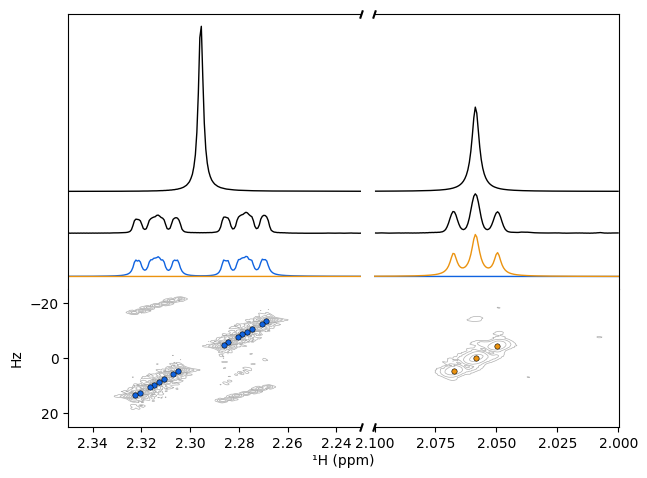

In [10]:
fig, _ = estimator_split.plot_result(**plot_kwargs)
fig.savefig(output_dir / "camphor_result_split.png")